### 3.1 Exploring the data


In [1]:
from sklearn.datasets import load_digits
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection

In [2]:
digits = load_digits ()


In [3]:
print(digits.keys())


dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])


In [4]:
data = digits["data"]
images = digits["images"]
target = digits["target"]
target_names = digits["target_names"]


In [5]:
print(data.dtype)
np.shape(data)


float64


(1797, 64)

Each of the 1797 pictures is composed of 64 pixels

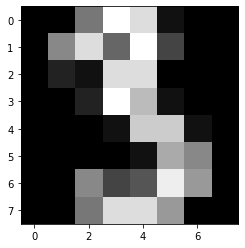

In [6]:
img = digits["images"][3]

assert2 = len(img.shape)
plt.figure()
plt.gray()
plt.imshow(img ,interpolation = "nearest") # Possible interpolations =" bicubic", "nearest"
plt.show()


In [7]:
X_all = data
y_all = target
X_train , X_test , y_train , y_test = model_selection.train_test_split(digits.data, digits.target, test_size = 0.4, random_state = 0)


In [8]:
print(np.shape(X_train))
print(np.shape(X_test))

(1078, 64)
(719, 64)


<span style ="color: green; font-weight: bold;  "> COMMENTS: It would better if images from both interpolation methods (nearest neightbour and bicubic) are displayed side by side for clear comparison. </span>

#### 3.2 Distance function computation using loops

In [9]:
def distance_matrix_loops(X_train, X_test):
    """
    arguments -- X_train: training data (N x D)
                 X_test: test data (M x D)
    ----------------------------------------
    output --   matrix = distance matrix of every pair of test-training points
    """

    mat = np.zeros((np.shape(X_train)[0], np.shape(X_test)[0]))
    for i in range(np.shape(X_train)[0]):
      for j in range(0 ,np.shape(X_test)[0]):
        mat[i][j] = np.linalg.norm(X_train[i] - X_test[j])
    return mat


<span style ="color: green; font-weight: bold;  "> COMMENTS: Slightly different from the suggested solution but results should be essentially correct. However, not sure whether 'np.linalg.norm' should be used here... </span>

#### 3.4 Vectorized implementation

In [10]:
#vectorized implementation
def dist_vec(training, test):
    """
    arguments -- training: training set of shape (N, D)
                 testing: evaluation set of shape (M, D)
    --------------------------------------
    output: distance matrix of shape (N, M)
    """ 
    return np.linalg.norm((training[:,None,:] - test[None,:,:]), axis=2) 

In [11]:
%timeit dist_vec(X_train, X_test) 

261 ms ± 31.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
%timeit distance_matrix_loops(X_train, X_test)

4.02 s ± 87 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


We can see that the vectorized implementation is significantly faster.

<span style ="color: green; font-weight: bold"> COMMENTS: Very smart and element vector implementation! Respect!!!</span>

#### Implementation of the K-NN classifier


In [13]:
def k_NN_classifier(X_train_local, Y_train_local, X_test_local,k):
    """
    auguments -- X_train_local : features training set (NxD)
                 Y_train_local : responses trainig set (1xN)
                 x_test_local : an array of testing data points (MxD)
                 k : number of NN to include in the set
    --------------------------------------------------------------
    output : np array of label predictions
    """
    Yassigned = []
    #distance_matrix = distance_matrix_loops(X_train_local, X_test_local)   #Using loops
    distance_matrix = dist_vec(X_train_local, X_test_local)    #Using vectorized approach
    for i in range(distance_matrix.shape[1]):
      index = np.argsort(distance_matrix[:,i])  #index corresponding to the shortest distance for instance i
      y_selected = Y_train_local[index][:k]
      pred = np.bincount(y_selected).argmax()
      Yassigned.append(pred) 
    Yassigned = np.array(Yassigned) 
    return Yassigned



def accuracy(Yassig, y_test):  
    return np.mean(Yassig == y_test)


<span style ="color: green; font-weight: bold"> COMMENTS: Slightly different approach from the suggested solution but essentially correct nevertheless. We really like the use of np.bincount().argmax(). Good job!
</span>


In [14]:
#Accuracy of the classifier with all data (not filtered)
k_values = [1, 3, 5, 9, 17, 33]

for k in k_values:
    Y_assigned = k_NN_classifier(X_train, y_train, X_test,k)
    acc = accuracy(Y_assigned, y_test)
    print('k = ' + str(k) + ', accuracy = ' + str(acc)  )

k = 1, accuracy = 0.9874826147426982
k = 3, accuracy = 0.9847009735744089
k = 5, accuracy = 0.9791376912378303
k = 9, accuracy = 0.9735744089012517
k = 17, accuracy = 0.9596662030598053
k = 33, accuracy = 0.9457579972183588


In [15]:
#Filter the data to get only 3 and 9 labels
train_filter = (y_train == 3) | (y_train == 9)
test_filter = (y_test == 3) | (y_test == 9)
y_train_filtered = y_train[train_filter]
y_test_filtered = y_test[test_filter]

In [16]:
X_train_filtered = X_train[train_filter]  #X_train which contains either 3 or 9 
X_test_filtered = X_test[test_filter]  #X_test which contains either 3 or 9

In [17]:
k_values = [1, 3, 5, 9, 17, 33]

for k in k_values:
    Y_assigned = k_NN_classifier(X_train_filtered, y_train_filtered, X_test_filtered,k)
    acc = accuracy(Y_assigned, y_test_filtered)
    print('k = ' + str(k) + ', accuracy = ' + str(acc))

k = 1, accuracy = 0.9861111111111112
k = 3, accuracy = 0.9930555555555556
k = 5, accuracy = 0.9930555555555556
k = 9, accuracy = 0.9930555555555556
k = 17, accuracy = 0.9930555555555556
k = 33, accuracy = 0.9791666666666666


Testing the k-NN-classifier for all the data, we saw already that the accuracy got slower with k. Our reasoning for that result was that, with this kind of features (images), the firts NNs were always more accurate, and increasing k (number of NNs to take the average with) was just introducing errors. \\

3 and 9, however, are very similar when represented as pixels in a picture. Therefore, increasing k does increase the accuracy at the beginning. There is a threshold value $k_{t}$, from which including the next NNs decreases the accuracy, for the same reason explained above.

In [18]:
#Other values of k, not for the exercise
k_values = [55, 101]
for k in k_values:
    Y_assigned = k_NN_classifier(X_train_filtered, y_train_filtered, X_test_filtered,k)
    acc = accuracy(Y_assigned, y_test_filtered)
    print('k = ' + str(k) + ', accuracy = ' + str(acc))

k = 55, accuracy = 0.9583333333333334
k = 101, accuracy = 0.9513888888888888


<span style ="color: green; font-weight: bold"> COMMENTS: Slightly different approach - showing accuracy instead of error rate. Also suggest to include a graph to visualize the results. </span>

## 4. Cross validation

In [19]:
#first we define a function to split the data into L folds

def split_folds(data, target, L):
    """
    auguments -- data : features training set (NxD)
                 target : responses trainig set (1xN)
                 L : number of folds to split the set to
    --------------------------------------------------------------
    output : matrix of folds of shape (L,N/L,D)
    """
    shuffled_a = np.empty(data.shape, dtype=data.dtype)
    shuffled_b = np.empty(target.shape, dtype=target.dtype)
    permutation = np.random.permutation(len(data))
    for old_index, new_index in enumerate(permutation):
        shuffled_a[new_index,:] = data[old_index,:]
        shuffled_b[new_index] = target[old_index]
        
    data_split = np.array_split(shuffled_a, L)  
    target_split = np.array_split(shuffled_b,L)
    return data_split, target_split

In [20]:
from sklearn.neighbors import KNeighborsClassifier

#Now we define a function, which, using the split_folds() function,
#performs the cross-validation for all possibilities of test set selection.

def crossvalid_us(data_whole,target_whole,L,k):
    #cross-validation using the k-NN classifier created by us
    a, b = split_folds(data_whole,target_whole,L)
    acc = []
    for i in range(L):
        test_x = a[i]
        test_y = b[i]
        train_x = a[1] if i==0 else a[0]
        train_y = b[1] if i==0 else b[0]
        for j in range(1,L):
            if j == i:
                continue
            if i == 0 & j == 1:
                continue
            train_x = np.append(train_x,a[j],axis=0)
            train_y = np.append(train_y,b[j],axis=0)
        pred_y = k_NN_classifier(train_x,train_y,test_x,k)
        acc.append(accuracy(pred_y,test_y))
    return [np.mean(acc), np.std(acc)]

def crossvalid_predef(data_whole,target_whole,L,k):
    #cross-validation using the k-NN classifier from sklearn
    a, b = split_folds(data_whole,target_whole,L)
    acc = []
    for i in range(L):
        test_x = a[i]
        test_y = b[i]
        train_x = a[1] if i==0 else a[0]
        train_y = b[1] if i==0 else b[0]
        for j in range(1,L):
            if j == i:
                continue
            if i == 0 & j == 1:
                continue
            train_x = np.append(train_x,a[j],axis=0)
            train_y = np.append(train_y,b[j],axis=0)
        neigh = KNeighborsClassifier(n_neighbors=k)
        neigh.fit(train_x, train_y)
        pred_y = neigh.predict(test_x)
        acc.append(accuracy(pred_y,test_y))
    return [np.mean(acc), np.std(acc)]


Now we compute the accuracy for various $L$

In [21]:
mean_us = []
mean_predef = []
std_us = []
std_predef = []
for l in [2,5,6,10,20]:
    res_us = crossvalid_us(data,target,l,1)
    mean_us.append(res_us[0])
    std_us.append(res_us[1])
    res_predef = crossvalid_predef(data,target,l,1)
    mean_predef.append(res_predef[0])
    std_predef.append(res_predef[1])

mean_usk = []
mean_predefk = []
std_usk = []
std_predefk = []
for l in [2,5,6,10,20]:
    res_us = crossvalid_us(data,target,l,3)
    mean_usk.append(res_us[0])
    std_usk.append(res_us[1])
    res_predefk = crossvalid_predef(data,target,l,3)
    mean_predefk.append(res_predefk[0])
    std_predefk.append(res_predefk[1])

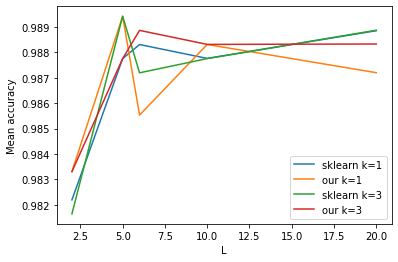

In [22]:
plt.plot([2,5,6,10,20],mean_predef, label = 'sklearn k=1')
plt.plot([2,5,6,10,20],mean_us, label = 'our k=1')
plt.plot([2,5,6,10,20],mean_predefk, label = 'sklearn k=3')
plt.plot([2,5,6,10,20],mean_usk, label = 'our k=3')
plt.xlabel('L')
plt.ylabel('Mean accuracy')
plt.legend()

On average, the accuracy increases with $L$, as with more folds we have a bigger train set.

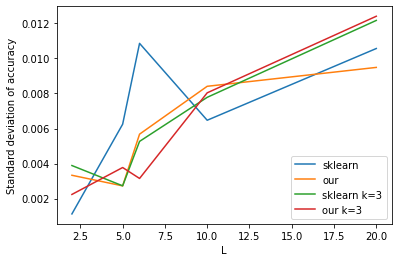

In [23]:
plt.plot([2,5,6,10,20],std_predef, label = 'sklearn')
plt.plot([2,5,6,10,20],std_us, label = 'our')
plt.plot([2,5,6,10,20],std_predefk, label = 'sklearn k=3')
plt.plot([2,5,6,10,20],std_usk, label = 'our k=3')
plt.xlabel('L')
plt.ylabel('Standard deviation of accuracy')
plt.legend()

We see that the standard deviation increases with $L$, as with larger $L$ the test set size decreases, and so the testing results have greater variance. All in all- more folds $L$ give a bigger train set meaning a better algorithm, but smaller test set meaning larger uncertainity of the computed accuracy.

<span style ="color: green; font-weight: bold"> COMMENTS: Correct obserations. Could improve by presenting the results in a table format as per suggested solution.
</span>